In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
from icecube import astro
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
from scipy import stats
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    #data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = cy.utils.ensure_dir('/data/user/ssclafani/data/analyses/DNNCascadeCodeReview/unblinding_checks/plots/unblinding/galactic_plane_checks')
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [8]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [9]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.0/'

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


In [10]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, 
        cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr


#### Get TrialRunners

In [11]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.


#### Get bkg fits for each template

In [12]:
tr  = tr_dict['pi0']

In [13]:
tr.to_dNdE(748, E0=1e5, unit=1)

2.4362604418196504e-18

In [14]:
bkg_file_dict = {
    'pi0': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'pi0'),
    'kra5': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra5'),
    'kra50': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra50'),
}
n_bkg_trials = 20000
seed = 1337

bkg_dict = {}
for key, tr in tr_dict.items():
    if key in bkg_file_dict:
        print('Loading background trials for template {}'.format(key))
        sig = np.load(bkg_file_dict[key], allow_pickle=True)
        bkg_dict[key] = sig['poisson']['nsig'][0.0]['ts']
    
    else:
        print('Running background trials for template {}'.format(key))
        bkg_dict[key] = tr.get_many_fits(
            n_trials=n_bkg_trials, seed=seed, mp_cpus=20)


Loading background trials for template pi0
Loading background trials for template kra5
Loading background trials for template kra50


#### Get Results for each template

In [15]:
res_dict = {}
for key in tr_dict.keys():
    f_path = os.path.join(
        cg.base_dir, 
        'gp/results/{}/{}_unblinded.npy'.format(key, key), 
    )
    res_dict[key] = np.load(f_path)

In [16]:
tr_dict

{'pi0': <csky.trial.TrialRunner at 0x7f3293af8510>,
 'kra5': <csky.trial.TrialRunner at 0x7f3293ae1fd0>,
 'kra50': <csky.trial.TrialRunner at 0x7f3291165790>}

In [17]:
def get_top_events(template_str, w, N, verbose=False):
    #Get Trial
    trial = tr_dict[template_str].get_one_trial(TRUTH=True)
    L = tr_dict[template_str].get_one_llh_from_trial(trial)
    print(L.fit(**tr_dict[template_str].fitter_args))
    
    ev = trial.evss[0][0] # something like that
    ev['rank'] = np.argsort(w)[::-1]
    top_ev = ev[ev.rank < N]

    data_inj = top_ev.inj[0]
    x = data_inj.data[top_ev.idx].as_dataframe
    if verbose:
        display(x)
    return x

In [18]:
def get_w(template_str, gamma=2.7):
    trial = tr_dict[template_str].get_one_trial(TRUTH=True)
    L = tr_dict[template_str].get_one_llh_from_trial(trial)
    print(L.fit(**tr_dict[template_str].fitter_args))
    
    space_eval = cy.inspect.get_space_eval(L, -1, 0) # 0: background events (1 would be for signal events)
    energy_eval = cy.inspect.get_energy_eval(L, -1, 0)
    StoB_space_ss = space_eval(gamma=gamma)[1] 
    SoB_energy = energy_eval(gamma=gamma)[0]
    SoB_space = space_eval(gamma=gamma)[0] 
    w = (SoB_space - StoB_space_ss) * SoB_energy
    return w, np.argsort(w)

In [19]:
def calc_N_events_for_2sigma(template_str, ws, verbose=False):
    trial = tr_dict[template_str].get_one_trial(TRUTH=True)    
    new_tss = []
    new_pvals = []
    new_sigmas = [] 
    #new_Es = [] 
    for i in range (40):
        trial2 = deepcopy(trial)
        if i == 0:
            mask = (np.isin(trial.evss[0][0].idx, 123412341234))
        else:
            top = ws[-i:]
            mask = (np.isin(trial.evss[0][0].idx, top))
            #print(top[-30:])

        missing_ev = trial2.evss[0][0][~mask]
        trial2.evss[0][0] = missing_ev
        L = tr_dict[template_str].get_one_llh_from_trial(trial2)
        new_ts, new_ns, gamma = L.fit(**tr_dict[template_str].fitter_args)
        pval = np.mean(bkg_dict[template_str] > new_ts)
        if verbose:
            print('Removing Top {} Events: TS= {:.2f} ns={:.2f}'.format(i, new_ts, new_ns['ns']))

            print('New pvalue: {:.2f}'.format(stats.norm.isf(pval)))
            print('-------------')
        new_pvals.append(pval)
        new_sigmas.append(stats.norm.isf(pval))
        new_tss.append(new_ts)
        if stats.norm.isf(pval) < 2:
            N_events = i
            break

    print('{} Events to be below 2sigma '.format(N_events))
    return N_events, new_tss, new_sigmas

In [18]:
def plot_removal_simgas(sigmas, N):
    plt.scatter(np.arange(0,N+.1,1), sigmas)
    plt.ylabel('N Sigma')
    plt.xlabel('N Top Events Removed')
    plt.ylim(1.5,5)
    plt.grid()
    plt.xlim(0,N + .2)

In [20]:
w_kra5, ws_kra5 = get_w('kra5', None)
#N_events_kra5, top_tss_kra5, top_sigmas_kra5= calc_N_events_for_2sigma('kra5', ws_kra5)
#x = get_top_events('kra5', w_kra5, N_events_kra5)
#plot_removal_simgas(top_sigmas_kra5, N_events_kra5)
#x.to_pickle('/home/ssclafani/top_events_kra5.pickle')


(19.033755068631105, {'ns': 273.24244005164337}, {})


In [21]:
w_kra5

array([ 0.0201668 , -0.1571104 ,  1.11220626, ..., -0.16921146,
        1.12441973,  3.3788513 ])

In [23]:
template_str = 'pi0'

In [42]:
trial = tr_dict[template_str].get_one_trial(TRUTH=True)    
new_tss = []
new_pvals = []
new_sigmas = [] 
#new_Es = [] 
for logE in np.linspace(8,6,11):
    trial2 = deepcopy(trial)
    mask = trial.evss[0][0].log10energy < logE
    missing_ev = trial2.evss[0][0][mask]
    trial2.evss[0][0] = missing_ev
    L = tr_dict[template_str].get_one_llh_from_trial(trial2)
    new_ts, new_ns, gamma = L.fit(**tr_dict[template_str].fitter_args)
    pval = np.mean(bkg_dict[template_str] > new_ts)
    
    print('Removing Events  logE < {}: TS= {:.2f} ns={:.2f}'.format(logE, new_ts, new_ns['ns']))
    print('New pvalue: {:.2f}'.format(stats.norm.isf(pval)))
    print('-------------')
    #new_pvals.append(pval)
    #new_sigmas.append(stats.norm.isf(pval))
    #new_tss.append(new_ts)
    #if stats.norm.isf(pval) < 2:
    #    N_events = i
    #    break



Removing Events  logE < 8.0: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 7.8: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 7.6: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 7.4: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 7.2: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 7.0: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 6.8: TS= 22.19 ns=748.11
New pvalue: 4.71
-------------
Removing Events  logE < 6.6: TS= 22.26 ns=749.53
New pvalue: 4.71
-------------
Removing Events  logE < 6.4: TS= 22.27 ns=749.52
New pvalue: 4.71
-------------
Removing Events  logE < 6.2: TS= 21.53 ns=737.86
New pvalue: 4.64
-------------
Removing Events  logE < 6.0: TS= 22.08 ns=749.36
New pvalue: 4.70
-------------


(19.033755068631105, {'ns': 273.24244005164337}, {})
15 Events to be below 2sigma 
(19.033755068631105, {'ns': 273.24244005164337}, {})


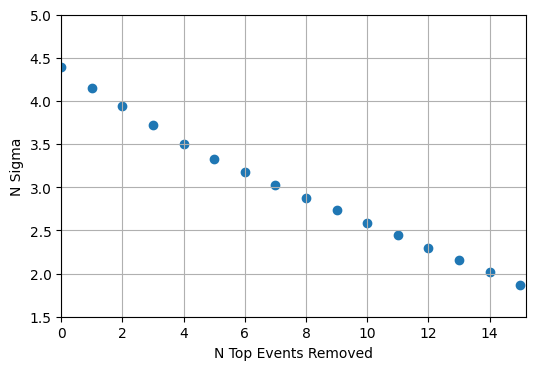

In [19]:
w_kra5, ws_kra5 = get_w('kra5', None)
N_events_kra5, top_tss_kra5, top_sigmas_kra5= calc_N_events_for_2sigma('kra5', ws_kra5)
x = get_top_events('kra5', w_kra5, N_events_kra5)
plot_removal_simgas(top_sigmas_kra5, N_events_kra5)
x.to_pickle('/home/ssclafani/top_events_kra5.pickle')


In [20]:
w_kra50, ws_kra50 = get_w('kra50', None)
N_events_kra50, top_tss_kra50, top_sigmas_kra50 = calc_N_events_for_2sigma('kra50', ws_kra50)
x = get_top_events('kra50', w_kra50, N_events_kra50)

x.to_pickle('/home/ssclafani/top_events_kra50.pickle')

(15.551087230759368, {'ns': 208.94803262085065}, {})
10 Events to be below 2sigma 
(15.551087230759368, {'ns': 208.94803262085065}, {})


In [21]:
w_pi0, ws_pi0 = get_w('pi0', 2.7)
N_events_pi0, top_tss_pi0, top_sigmas_pi0 = calc_N_events_for_2sigma('pi0', ws_pi0)
x = get_top_events('pi0', w_pi0, N_events_pi0, verbose=True)
x.to_pickle('/home/ssclafani/top_events_pi0.pickle')

(22.188404164707155, {'ns': 748.1128410012386}, {'gamma': 2.7})
27 Events to be below 2sigma 
(22.188404164707155, {'ns': 748.1128410012386}, {'gamma': 2.7})


,azimuth,dec,sindec,energy,log10energy,event,mjd,ra,run,sigma,subevent
0,2.944438,-0.040470,-0.040459,1008.482361,3.003668,18174924,55817.405609,1.034041,118682,0.621940,0
1,5.695859,0.364923,0.356878,1865.459473,3.270786,33421030,56124.795364,6.019483,120451,0.185013,0
2,5.670975,-0.104176,-0.103988,525.178711,2.720307,62942812,56298.447906,0.565348,121537,0.692981,0
3,1.761321,0.644119,0.600495,865.433472,2.937234,78087993,56352.420019,5.228254,121945,0.396460,0
4,1.859584,-0.267584,-0.264402,568.855286,2.755002,37475054,56385.533064,0.126724,122138,0.258220,0
5,3.798596,0.451693,0.436489,1051.614502,3.021857,67705981,56495.278432,4.758929,122699,0.477548,0
6,1.293632,-0.125248,-0.124921,570.939575,2.756590,58086465,56616.823919,0.215838,123271,0.380637,0
7,1.345427,1.321048,0.968975,527.547058,2.722261,66964446,56655.381129,4.328388,123572,0.483991,0
8,1.567556,-0.636381,-0.594289,2184.337402,3.339320,23963893,57134.965112,3.459346,126285,0.174417,0
9,1.738049,-0.242078,-0.239721,6829.437500,3.834385,6844153,57202.999491,4.675243,126531,0.234515,0


In [41]:
def plot_highest(template_str, N, ws, coord='equa'):
    fig, ax = plt.subplots()
    trial = tr_dict[template_str].get_one_trial(TRUTH=True)
    es = []
    ls = []
    bs = []
    decs = []
    ras = []
    sigmas = []
    for a in ws[-N:][::-1]:
        mask = trial.evss[0][0].idx == a
        dec = trial.evss[0][0][mask].dec[0]
        ra = trial.evss[0][0][mask].ra[0]
        e = trial.evss[0][0][mask].energy[0]
        ras.append(ra)
        decs.append(dec)
        es.append(e)
        sigma = trial.evss[0][0][mask].sigma[0]    
        sigmas.append(sigma)
        l, b = astro.equa_to_gal(float(ra), float(dec))
        ls.append(l)
        bs.append(b)
        print('ID: {} RA: {:.2f} DEC: {:.2f} E:{:.1f} SIGMA: {:2f}'.format(a, np.degrees(ra), np.degrees(dec),
                                                                e , np.degrees(sigma)))
    if coord == 'galactic':
        ls = np.array(ls)
        ls[ls>np.pi] -= 2*np.pi
        
        
        plt.scatter(np.degrees(ls), np.degrees(bs), marker='.', edgecolors='k', s=100) 
        plt.xlabel('galactic (l)')
        plt.axhline(0, c='k')
        plt.ylabel('galactic (b)')
        plt.xlim(-180,180)
        ticks = ax.get_xticks()
        ticks[ticks < 0] += 360
        ax.set_xticklabels([int(tick) for tick in ticks])
        plt.ylim(-10,10)
        plt.scatter(0,0, c='r', marker='x')
        plt.title('Distribution of highest {} events'.format(N))
    if coord =='equa':
        plt.title('Distribution of highest {} events'.format(N))
        plt.scatter(np.degrees(ras), np.degrees(decs), s=np.pi*np.degrees(sigma)**2, marker='.', edgecolors='k', )
        plt.scatter(266.41500889, -29.00, marker='x', c='r', label='Galactic Center')
        plt.xlabel('RA[degrees]')
        plt.ylim(-90,0)
        plt.xlim(360,0)
        plt.ylabel('DEC[degrees]')
        plt.legend()
    plt.show()
    return ras, decs, sigmas, es

ID: 473 RA: 271.80 DEC: -28.82 E:103288.5 SIGMA: 5.786295
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 50307 RA: 275.41 DEC: -27.34 E:23796.5 SIGMA: 5.702135
ID: 1308 RA: 250.99 DEC: -39.30 E:29093.2 SIGMA: 4.368791
ID: 38947 RA: 264.32 DEC: -36.50 E:11193.1 SIGMA: 4.758223
ID: 54169 RA: 271.35 DEC: -17.99 E:56211.7 SIGMA: 5.730005
ID: 9910 RA: 262.68 DEC: -28.68 E:8158.8 SIGMA: 4.403172
ID: 25980 RA: 252.03 DEC: -46.98 E:7181.0 SIGMA: 3.961936
ID: 378 RA: 271.67 DEC: -18.38 E:37171.0 SIGMA: 5.607180
ID: 25997 RA: 258.69 DEC: -45.33 E:33669.7 SIGMA: 5.285249
ID: 37139 RA: 279.54 DEC: -14.41 E:43698.0 SIGMA: 4.230784


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


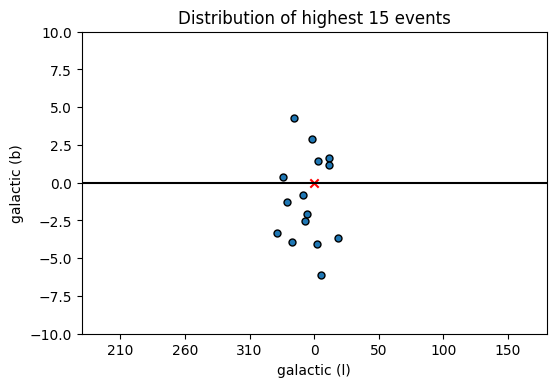

ID: 473 RA: 271.80 DEC: -28.82 E:103288.5 SIGMA: 5.786295
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 50307 RA: 275.41 DEC: -27.34 E:23796.5 SIGMA: 5.702135
ID: 1308 RA: 250.99 DEC: -39.30 E:29093.2 SIGMA: 4.368791
ID: 38947 RA: 264.32 DEC: -36.50 E:11193.1 SIGMA: 4.758223
ID: 54169 RA: 271.35 DEC: -17.99 E:56211.7 SIGMA: 5.730005
ID: 9910 RA: 262.68 DEC: -28.68 E:8158.8 SIGMA: 4.403172
ID: 25980 RA: 252.03 DEC: -46.98 E:7181.0 SIGMA: 3.961936
ID: 378 RA: 271.67 DEC: -18.38 E:37171.0 SIGMA: 5.607180
ID: 25997 RA: 258.69 DEC: -45.33 E:33669.7 SIGMA: 5.285249
ID: 37139 RA: 279.54 DEC: -14.41 E:43698.0 SIGMA: 4.230784


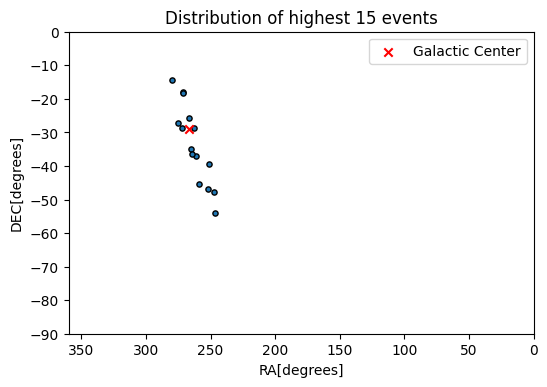

In [42]:
_,_,top_unc_kra5, top_Es_kra5 =  plot_highest('kra5', N_events_kra5, ws_kra5, coord='galactic')
_ = plot_highest('kra5', N_events_kra5, ws_kra5, coord='equa')

ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 1373 RA: 268.70 DEC: -24.99 E:866616.8 SIGMA: 4.229523
ID: 25980 RA: 252.03 DEC: -46.98 E:7181.0 SIGMA: 3.961936
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 18187 RA: 242.27 DEC: -55.89 E:20748.0 SIGMA: 5.454351
ID: 8836 RA: 235.00 DEC: -54.67 E:13688.0 SIGMA: 5.564590
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 30475 RA: 238.47 DEC: -55.46 E:23954.2 SIGMA: 6.251959
ID: 24973 RA: 231.53 DEC: -54.29 E:26507.0 SIGMA: 5.492816
ID: 54961 RA: 252.86 DEC: -43.27 E:5219.7 SIGMA: 3.736714
ID: 1308 RA: 250.99 DEC: -39.30 E:29093.2 SIGMA: 4.368791
ID: 25997 RA: 258.69 DEC: -45.33 E:33669.7 SIGMA: 5.285249
ID: 23063 RA: 245.36 DEC: -53.89 E:44297.3 SIGMA: 5.763471
ID: 54949 RA: 288.07 DEC: 5.35 E:255217.8 SIGMA: 5.806482
ID: 24142 RA: 207.17 DEC: -65.67 E:12872.7 SIGMA: 5.546120
ID

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


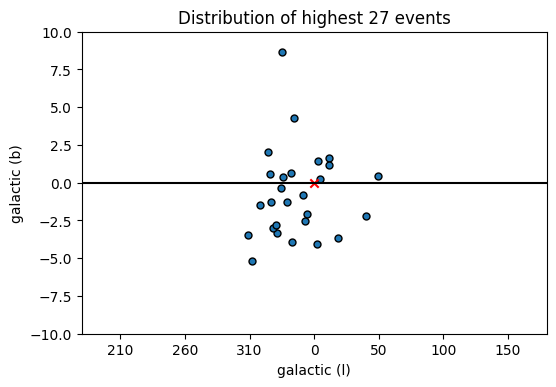

ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 1373 RA: 268.70 DEC: -24.99 E:866616.8 SIGMA: 4.229523
ID: 25980 RA: 252.03 DEC: -46.98 E:7181.0 SIGMA: 3.961936
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 18187 RA: 242.27 DEC: -55.89 E:20748.0 SIGMA: 5.454351
ID: 8836 RA: 235.00 DEC: -54.67 E:13688.0 SIGMA: 5.564590
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 30475 RA: 238.47 DEC: -55.46 E:23954.2 SIGMA: 6.251959
ID: 24973 RA: 231.53 DEC: -54.29 E:26507.0 SIGMA: 5.492816
ID: 54961 RA: 252.86 DEC: -43.27 E:5219.7 SIGMA: 3.736714
ID: 1308 RA: 250.99 DEC: -39.30 E:29093.2 SIGMA: 4.368791
ID: 25997 RA: 258.69 DEC: -45.33 E:33669.7 SIGMA: 5.285249
ID: 23063 RA: 245.36 DEC: -53.89 E:44297.3 SIGMA: 5.763471
ID: 54949 RA: 288.07 DEC: 5.35 E:255217.8 SIGMA: 5.806482
ID: 24142 RA: 207.17 DEC: -65.67 E:12872.7 SIGMA: 5.546120
ID

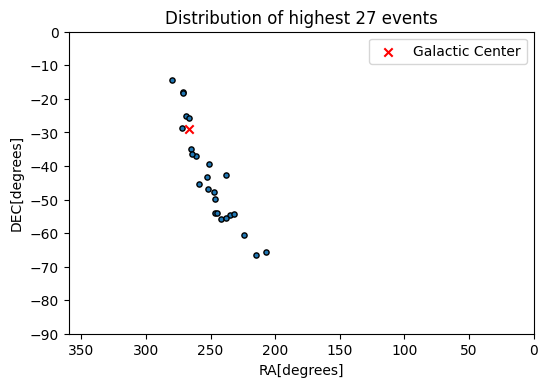

In [43]:
_,_,top_unc_pi0, top_Es_pi0 = plot_highest('pi0', N_events_pi0, ws_pi0, coord='galactic')
_ = plot_highest('pi0', N_events_pi0, ws_pi0, coord='equa')

ID: 473 RA: 271.80 DEC: -28.82 E:103288.5 SIGMA: 5.786295
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 1373 RA: 268.70 DEC: -24.99 E:866616.8 SIGMA: 4.229523
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 20062 RA: 275.12 DEC: -35.95 E:133363.0 SIGMA: 10.357719
ID: 54169 RA: 271.35 DEC: -17.99 E:56211.7 SIGMA: 5.730005
ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 50307 RA: 275.41 DEC: -27.34 E:23796.5 SIGMA: 5.702135


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


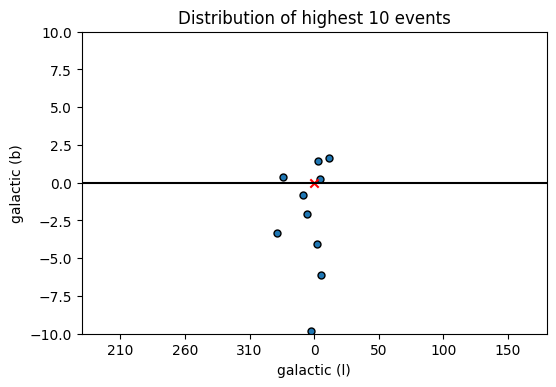

ID: 473 RA: 271.80 DEC: -28.82 E:103288.5 SIGMA: 5.786295
ID: 52117 RA: 264.95 DEC: -34.91 E:40522.7 SIGMA: 3.671503
ID: 12286 RA: 261.44 DEC: -36.96 E:34703.5 SIGMA: 3.458009
ID: 1373 RA: 268.70 DEC: -24.99 E:866616.8 SIGMA: 4.229523
ID: 14488 RA: 266.63 DEC: -25.82 E:25157.1 SIGMA: 5.150141
ID: 13232 RA: 246.35 DEC: -54.00 E:113948.9 SIGMA: 4.912322
ID: 20062 RA: 275.12 DEC: -35.95 E:133363.0 SIGMA: 10.357719
ID: 54169 RA: 271.35 DEC: -17.99 E:56211.7 SIGMA: 5.730005
ID: 56131 RA: 247.59 DEC: -47.88 E:7581.1 SIGMA: 2.772263
ID: 50307 RA: 275.41 DEC: -27.34 E:23796.5 SIGMA: 5.702135


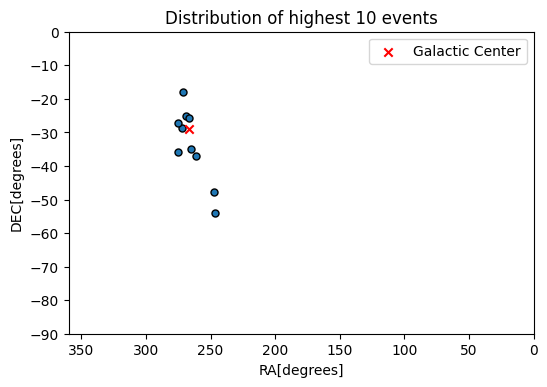

In [44]:
_,_,top_unc_kra50, top_Es_kra50 = plot_highest('kra50', N_events_kra50, ws_kra50, coord='galactic')
_ = plot_highest('kra50', N_events_kra50, ws_kra50, coord='equa')

Text(0.5, 1.0, 'Top Events required to drop signifigance to 2sigma')

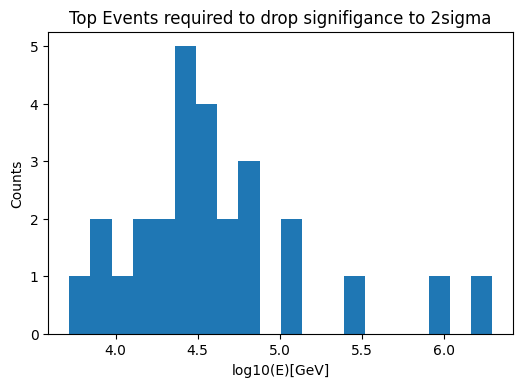

In [40]:
plt.hist(np.log10(top_Es_pi0), bins=20)
plt.xlabel('log10(E)[GeV]')
#plt.xlim(3,7)
plt.ylabel('Counts')
plt.title('Top Events required to drop signifigance to 2sigma')

In [ ]:
plt.hist(np.degrees(top_unc_pi0), bins=20)
plt.xlabel('Sigma[Degrees]')
plt.xlim(0,15)
plt.ylabel('Counts')
plt.title('Top Events required to drop signifigance to 2sigma')